In [3]:
cd /data/store01/data_dirs/students/ucfafyi/S2_MODIS

/data/store01/data_dirs/students/ucfafyi/S2_MODIS


In [4]:
import os
import sys
sys.path.insert(0,'python')
from PSF_optimization import *
from fastRWpkl import *
from get_wrs import *
from linear_plot import *
from smoothn import *
plot_config()
import pylab as plt
%matplotlib inline

/home/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [5]:
directory = os.getcwd()+'/'
lat, lon, year = 37.474469, 117.346456, 2016
h,v = mtile_cal(lat, lon)
pr=get_wrs(lat, lon)
path, row = pr[0]['path'],pr[0]['row']
Hfiles = glob.glob(directory +'l_data/LC8%03d%03d%d*LGN00_sr_band1.tif'%(path, row, year))

doys = [int(i.split('2016')[1][:3]) for i in Hfiles]
doys

[38, 70, 86, 134, 150]

In [6]:
def read_meta(Hfile):
    
    with open(Hfile[:-4]+'_MTL.txt', 'r') as inF:
        for line in inF:
            if 'CLOUD_COVER ' in line:
                cloud_cover =  float(line.split('= ')[1])
    if cloud_cover<20:
        #print 'Less than 20% cloud.'
        b1 = gdal.Open(Hfile+'band1.tif').ReadAsArray()
        corners = b1.shape
        dic = {}
        with open(Hfile[:-4]+'_MTL.txt', 'r') as inF:
            for line in inF:
                if ('CORNER_' in line)&('LAT_PRODUCT' in line):
                    dic[line.split(' = ')[0].strip()[7:13]] = float(line.split(' = ')[1])
                elif ('CORNER_' in line)&('LON_PRODUCT' in line):
                    dic[line.split(' = ')[0].strip()[7:13]] = float(line.split(' = ')[1])
                elif 'ROLL_ANGLE' in line:
                    vza = float(line.split(' = ')[1])
                elif 'SUN_AZIMUTH' in line:
                    saa = float(line.split(' = ')[1])
                elif 'SUN_ELEVATION' in line:
                    sza = float(line.split(' = ')[1])
        with open('Landsat_azm.pkl', 'r') as savefile:
            Landsat_azm = pkl.load(savefile)

        vaa = np.nanmean(Landsat_azm[(Landsat_azm[:,2]==path)&(Landsat_azm[:,3]==row)].squeeze()[:2])
        
        return sza, saa, vza, vaa, dic, corners
    else:
        print 'To much cloud: ', cloud_cover
        return None  
sza, saa, vza, vaa, dic, corners = read_meta('l_data/LC81220342016038LGN00_sr_')
L_inds, H_inds = ML_geo_trans(lat, lon, dic, corners)
Lx, Ly = L_inds
Hx, Hy = H_inds

In [7]:
fnames = [i.split('/')[-1].split('_sr')[0] for i in Hfiles]
fnames

['LC81220342016038LGN00',
 'LC81220342016070LGN00',
 'LC81220342016086LGN00',
 'LC81220342016134LGN00',
 'LC81220342016150LGN00']

In [8]:
from datetime import date
[date.fromordinal(date(year, 1, 1).toordinal() + days - 1) for days in [38, 70, 86, 134, 150]]

[datetime.date(2016, 2, 7),
 datetime.date(2016, 3, 10),
 datetime.date(2016, 3, 26),
 datetime.date(2016, 5, 13),
 datetime.date(2016, 5, 29)]

In [9]:
L38 = parallel_rw_pkl(None, 'LC81220342016038LGN00'+'PSF', 'r')
L70 = parallel_rw_pkl(None, 'LC81220342016070LGN00'+'PSF', 'r')

In [10]:
L86 = parallel_rw_pkl(None, 'LC81220342016086LGN00'+'PSF', 'r')
L134 = parallel_rw_pkl(None, 'LC81220342016134LGN00'+'PSF', 'r')
L150 = parallel_rw_pkl(None, 'LC81220342016150LGN00'+'PSF', 'r')

In [11]:
L38_para = [i[0] for i in L38[0]]
L38_cost = [i[1] for i in L38[0]]
L70_para = [i[0] for i in L70[0]]
L70_cost = [i[1] for i in L70[0]]
L86_para = [i[0] for i in L86[0]]
L86_cost = [i[1] for i in L86[0]]
L134_para = [i[0] for i in L134[0]]
L134_cost = [i[1] for i in L134[0]]
L150_para = [i[0] for i in L150[0]]
L150_cost = [i[1] for i in L150[0]]

/home/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


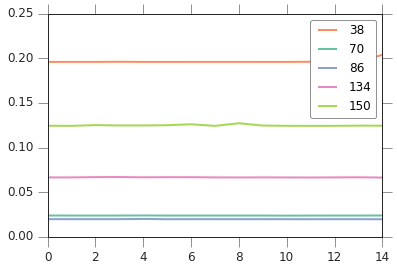

In [10]:
plt.plot(L38_cost, label='38')
plt.plot(L70_cost, label='70')
plt.plot(L86_cost, label = '86')
plt.plot(L134_cost, label = '134')
plt.plot(L150_cost, label = '150')
plt.legend()

In [23]:
al = np.vstack((L70_para, L86_para, L134_para, L150_para))

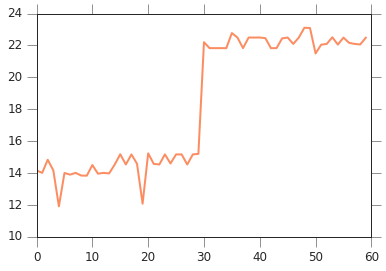

In [25]:
plt.plot([], al[:,1], '+')

In [32]:
BRDF_16_days = L38[1]
mask = BRDF_16_days[8,1,:]<=0

(0, 16)

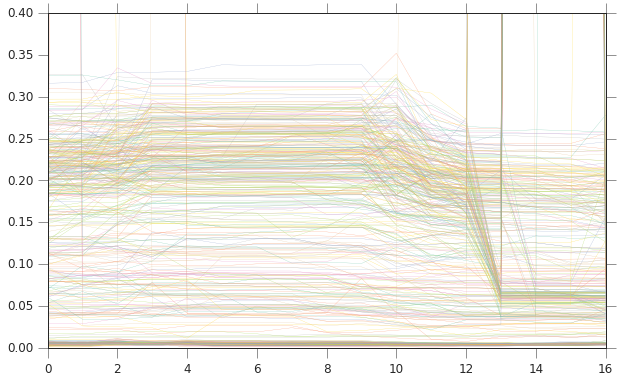

In [38]:
ran = np.random.choice(range(len(BRDF_16_days[8,0,mask])), 500)
plt.figure(figsize=(10,6))
plt.plot(BRDF_16_days[:,0,mask][:,ran], lw=0.2)
plt.ylim(0.,0.4)
plt.xlim(0,16)

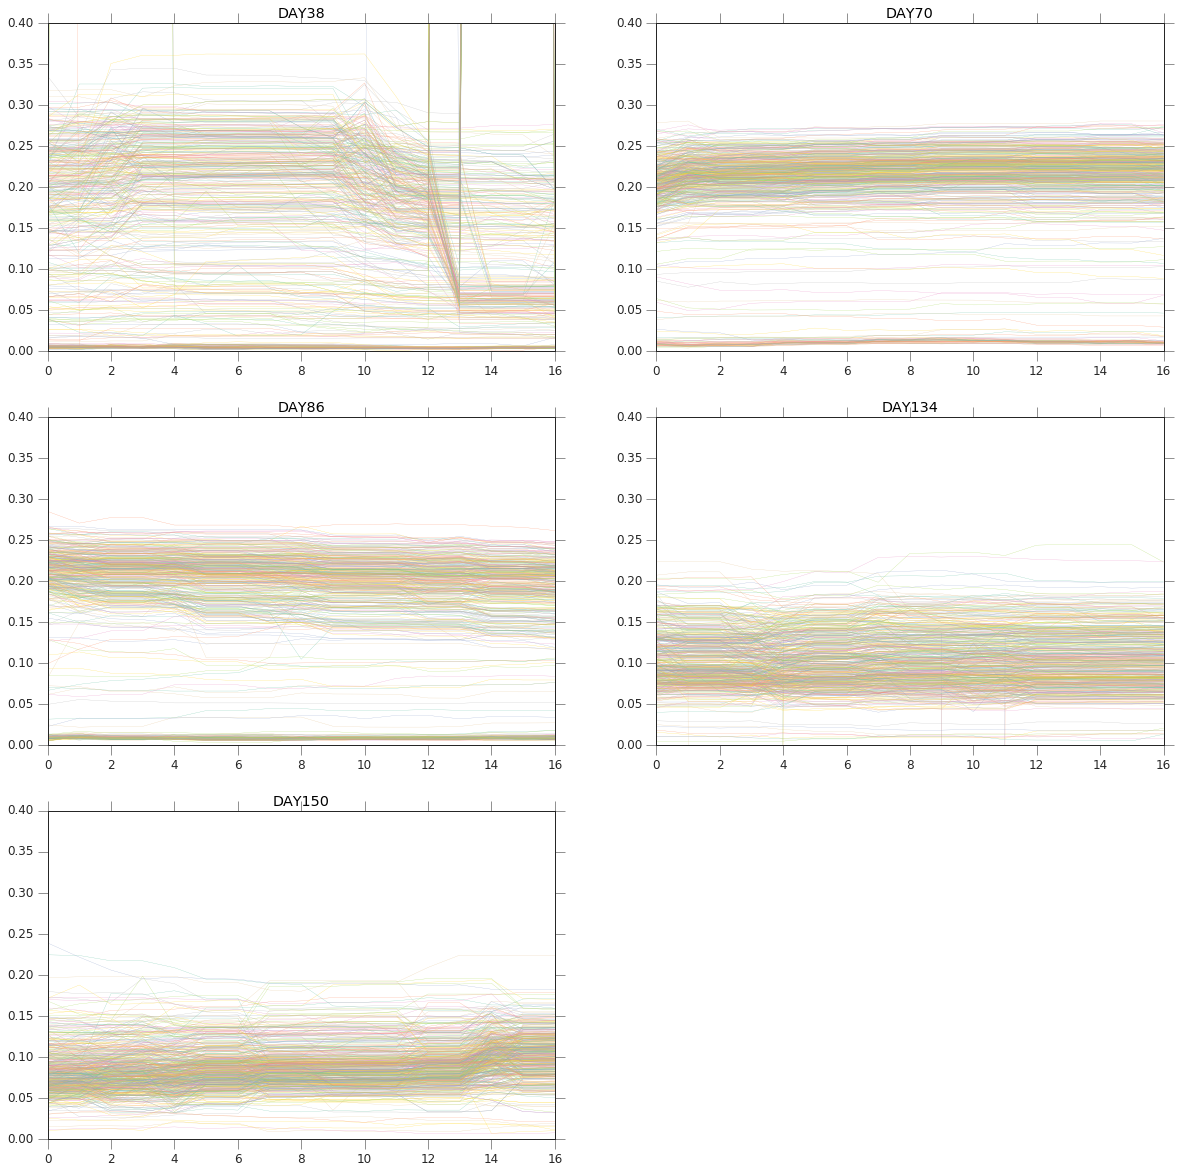

In [48]:
fig = plt.figure(figsize=(20,20))
tis = ['38', '70', '86', '134', '150']
for i, f in enumerate([L38, L70, L86, L134, L150]):
    mask = f[1][8,1,:]<=0
    ran = np.random.choice(range(len(f[1][8,0,mask])), 500)
    ax = fig.add_subplot(3,2,i+1)
    ax.plot(f[1][:,0,mask][:,ran], lw=0.2)
    ax.set_ylim(0.,0.4)
    ax.set_xlim(0,16)
    ax.set_title('DAY'+tis[i])

In [13]:
doy = 38
files = [glob.glob('m_data/MOD09*.A2016%03d.h27v05.006.*.hdf'%i)[0] for i in range(doy-8, doy+8+1)]
files

['m_data/MOD09GA.A2016030.h27v05.006.2016033020241.hdf',
 'm_data/MOD09GA.A2016031.h27v05.006.2016033090314.hdf',
 'm_data/MOD09GA.A2016032.h27v05.006.2016034072418.hdf',
 'm_data/MOD09GA.A2016033.h27v05.006.2016036012218.hdf',
 'm_data/MOD09GA.A2016034.h27v05.006.2016036062504.hdf',
 'm_data/MOD09GA.A2016035.h27v05.006.2016037064753.hdf',
 'm_data/MOD09GA.A2016036.h27v05.006.2016038063739.hdf',
 'm_data/MOD09GA.A2016037.h27v05.006.2016039190639.hdf',
 'm_data/MOD09GA.A2016038.h27v05.006.2016040113516.hdf',
 'm_data/MOD09GA.A2016039.h27v05.006.2016041112033.hdf',
 'm_data/MOD09GA.A2016040.h27v05.006.2016042072359.hdf',
 'm_data/MOD09GA.A2016041.h27v05.006.2016043071326.hdf',
 'm_data/MOD09GA.A2016042.h27v05.006.2016044063336.hdf',
 'm_data/MOD09GA.A2016043.h27v05.006.2016045065209.hdf',
 'm_data/MOD09GA.A2016044.h27v05.006.2016046211343.hdf',
 'm_data/MOD09GA.A2016045.h27v05.006.2016047063215.hdf',
 'm_data/MOD09GA.A2016046.h27v05.006.2016048065027.hdf']

In [113]:
temp1 = 'HDF4_EOS:EOS_GRID:"%s":MODIS_Grid_1km_2D:SensorZenith_1'
temp2 = 'HDF4_EOS:EOS_GRID:"%s":MODIS_Grid_1km_2D:SensorAzimuth_1'
temp3 = 'HDF4_EOS:EOS_GRID:"%s":MODIS_Grid_1km_2D:SolarZenith_1'
temp4 = 'HDF4_EOS:EOS_GRID:"%s":MODIS_Grid_1km_2D:SolarAzimuth_1'
temp5 = 'HDF4_EOS:EOS_GRID:"%s":MODIS_Grid_500m_2D:sur_refl_b07_1'
temp6 = 'HDF4_EOS:EOS_GRID:"%s":MODIS_Grid_500m_2D:sur_refl_b01_1'
temp7 = 'HDF4_EOS:EOS_GRID:"%s":MODIS_Grid_500m_2D:sur_refl_b02_1'
temp8 = 'HDF4_EOS:EOS_GRID:"%s":MODIS_Grid_500m_2D:QC_500m_1'

In [130]:
Ref_17_days = []
for fname in files:
    print fname
    data = []
    for temp in [temp1, temp2, temp3, temp4, temp5, temp6, temp7, temp8]:
        #print temp%fname
        dat = gdal.Open(temp%fname).ReadAsArray()
        if dat.shape !=(2400,2400):
            dat = np.repeat(np.repeat(dat,2, axis=1), 2, axis=0)
        data.append(dat)
            
    mask =  bitwise_and(data[7], 3)
    #aved = np.array(data).reshape((2,2400,2,2400,2)).mean(axis=4).mean(2)
    Ref_17_days.append(data[:7]+ [mask,])

m_data/MOD09GA.A2016030.h27v05.006.2016033020241.hdf
m_data/MOD09GA.A2016031.h27v05.006.2016033090314.hdf
m_data/MOD09GA.A2016032.h27v05.006.2016034072418.hdf
m_data/MOD09GA.A2016033.h27v05.006.2016036012218.hdf
m_data/MOD09GA.A2016034.h27v05.006.2016036062504.hdf
m_data/MOD09GA.A2016035.h27v05.006.2016037064753.hdf
m_data/MOD09GA.A2016036.h27v05.006.2016038063739.hdf
m_data/MOD09GA.A2016037.h27v05.006.2016039190639.hdf
m_data/MOD09GA.A2016038.h27v05.006.2016040113516.hdf
m_data/MOD09GA.A2016039.h27v05.006.2016041112033.hdf
m_data/MOD09GA.A2016040.h27v05.006.2016042072359.hdf
m_data/MOD09GA.A2016041.h27v05.006.2016043071326.hdf
m_data/MOD09GA.A2016042.h27v05.006.2016044063336.hdf
m_data/MOD09GA.A2016043.h27v05.006.2016045065209.hdf
m_data/MOD09GA.A2016044.h27v05.006.2016046211343.hdf
m_data/MOD09GA.A2016045.h27v05.006.2016047063215.hdf
m_data/MOD09GA.A2016046.h27v05.006.2016048065027.hdf


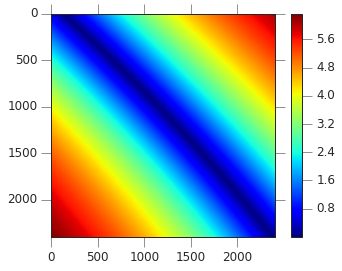

In [167]:
plt.imshow(Ref_17_days[0][0]*0.001)
plt.colorbar()

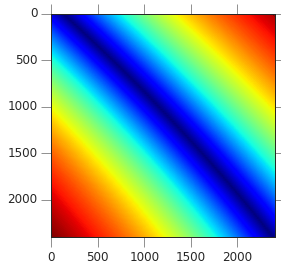

In [129]:
plt.imshow(np.repeat(np.repeat(Ref_17_days[0][0],2, axis=1), 2, axis=0))

In [132]:
Ref_17_days = np.array(Ref_17_days)

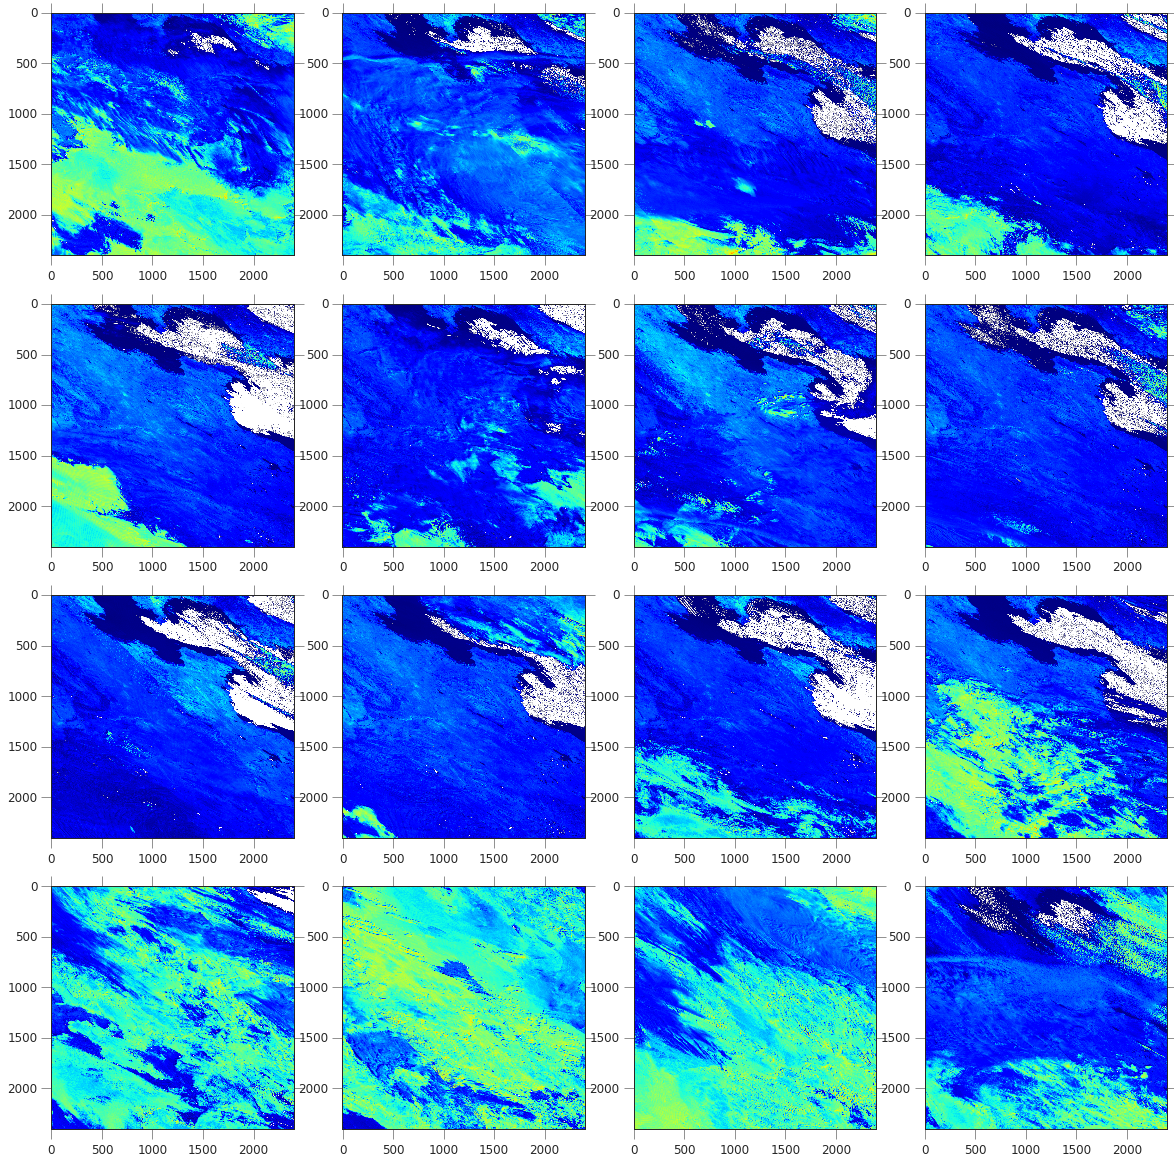

In [117]:
fig = plt.figure(figsize=(20,20))
for i in range(16):
    ax = fig.add_subplot(4,4, i+1)
    ax.imshow(ma.array(Ref_17_days[i][4], mask = Ref_17_days[i][-1]>0), vmin=0, vmax=10000)

In [133]:
Ref_17_days.shape

(17, 8, 2400, 2400)

In [134]:
ndvi = (Ref_17_days[:,-2,:,:]-Ref_17_days[:,-3,:,:])*0.0001/ ((Ref_17_days[:,-2,:,:]+Ref_17_days[:,-3,:,:])*0.0001)

/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


In [135]:
ndvi

array([[[  2.12407283e-02,   2.73609885e-02,   1.90532312e-02, ...,
          -9.86013986e-02,  -9.86013986e-02,  -4.85744456e-02],
        [  2.65011741e-02,   2.86602210e-02,   3.29985653e-02, ...,
          -2.05032619e-03,  -2.05032619e-03,  -9.86013986e-02],
        [  2.11623500e-02,   2.33927695e-02,   2.77112556e-02, ...,
           4.45912469e-03,   4.97000857e-03,  -3.60620267e-03],
        ..., 
        [  1.06642035e-02,   6.91562932e-03,   6.91562932e-03, ...,
           3.78341500e-03,   5.19757029e-03,   3.59850919e-03],
        [  4.51540074e-03,   1.06642035e-02,   1.06642035e-02, ...,
           5.16087926e-03,   5.16087926e-03,   3.53675005e-03],
        [  4.51540074e-03,   7.52823087e-03,   7.52823087e-03, ...,
           3.09238500e-03,   2.31154488e-03,   2.65789141e-03]],

       [[  1.69008430e-01,   2.30043256e-01,   2.41527703e-01, ...,
          -2.23318939e-02,  -2.21635884e-03,  -8.69250272e-03],
        [  2.05882353e-01,   1.69008430e-01,   1.69008430e-0

(0, 16)

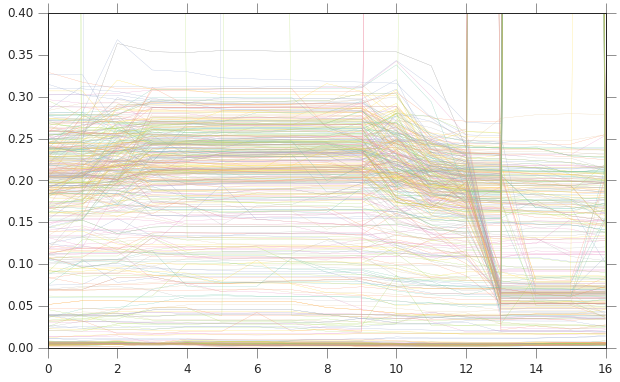

In [72]:
BRDF_16_days = L38[1]
mask = BRDF_16_days[8,1,:]<=0
ran = np.random.choice(range(len(BRDF_16_days[8,0,mask])), 500)
plt.figure(figsize=(10,6))
plt.plot(BRDF_16_days[:,0,mask][:,ran], lw=0.2)
plt.ylim(0.,0.4)
plt.xlim(0,16)

In [162]:
band7 = (Ref_17_days[:,4, Lx, Ly][:,ran]*0.0001).copy()
mask = np.zeros_like(band7)
mask[12:15] = 1
mask = mask.astype(bool)

(0, 16)

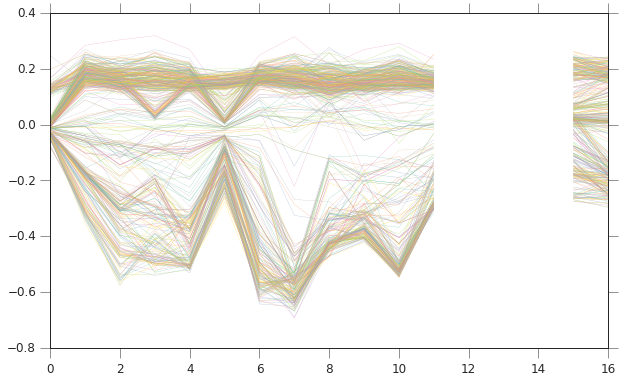

In [164]:
plt.figure(figsize=(10,6))
plt.plot(ma.array(ndvi[:,Lx, Ly][:,ran], mask= mask), lw=0.2)
plt.xlim(0,16)
#plt.ylim(0, 0.8)

(0, 0.8)

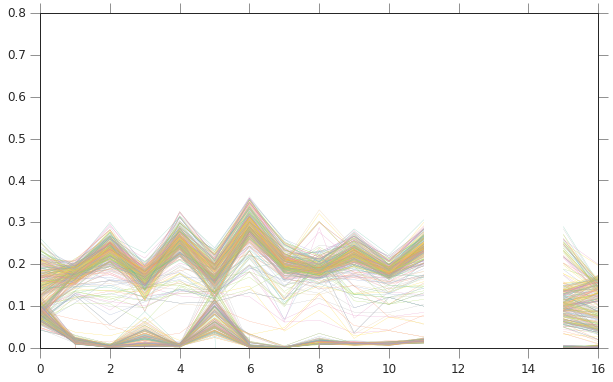

In [234]:
plt.figure(figsize=(10,6))
plt.plot(ma.array(band7, mask=mask), lw=0.2)
plt.xlim(0,16)
plt.ylim(0,0.8)

(0, 0.8)

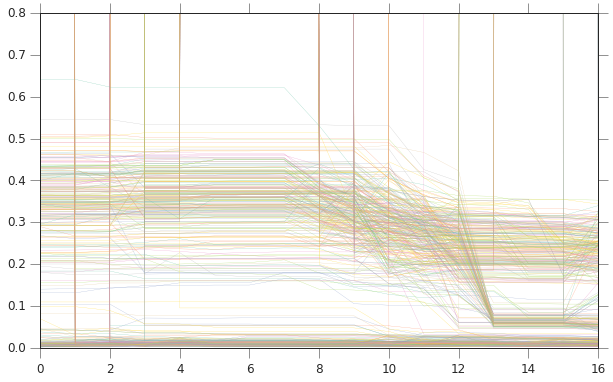

In [258]:
plt.figure(figsize=(10,6))
plt.plot(predic[:,0,ran], lw=0.2)
plt.xlim(0,16)
plt.ylim(0,0.8)

(0, 16)

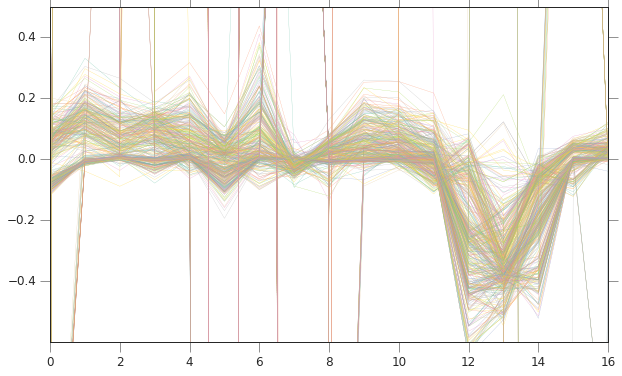

In [251]:
plt.figure(figsize=(10,6))
plt.plot((predic[:,0,ran]-band7), '-', lw=0.2)
plt.ylim(-0.6,0.5)
plt.xlim(0,16)

In [177]:
angles = Ref_17_days[:,:4,Lx,Ly]

(0, 16)

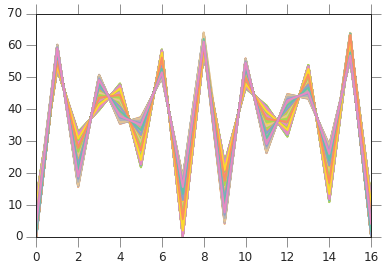

In [184]:
plt.plot((angles*0.01)[:,0,ran])
plt.xlim(0,16)

In [191]:
mang = (angles*0.01)[:,:,ran].mean(axis=-1)

In [224]:
raa = mang[:,1]-mang[:,-1]
angs = np.vstack((mang[:,:2].T, raa)).T

In [259]:
Lfiles = [glob.glob('m_data/MCD43A1.A%d%03d.h%02dv%02d.006.*.hdf'%(2016,i,27,5))[0] for i in range(1,300)]
Lfiles

['m_data/MCD43A1.A2016001.h27v05.006.2016174080325.hdf',
 'm_data/MCD43A1.A2016002.h27v05.006.2016174083522.hdf',
 'm_data/MCD43A1.A2016003.h27v05.006.2016174090315.hdf',
 'm_data/MCD43A1.A2016004.h27v05.006.2016174092543.hdf',
 'm_data/MCD43A1.A2016005.h27v05.006.2016174095310.hdf',
 'm_data/MCD43A1.A2016006.h27v05.006.2016174102402.hdf',
 'm_data/MCD43A1.A2016007.h27v05.006.2016174105309.hdf',
 'm_data/MCD43A1.A2016008.h27v05.006.2016174112041.hdf',
 'm_data/MCD43A1.A2016009.h27v05.006.2016174114733.hdf',
 'm_data/MCD43A1.A2016010.h27v05.006.2016174121454.hdf',
 'm_data/MCD43A1.A2016011.h27v05.006.2016174123916.hdf',
 'm_data/MCD43A1.A2016012.h27v05.006.2016174130554.hdf',
 'm_data/MCD43A1.A2016013.h27v05.006.2016174133417.hdf',
 'm_data/MCD43A1.A2016014.h27v05.006.2016174135746.hdf',
 'm_data/MCD43A1.A2016015.h27v05.006.2016174141634.hdf',
 'm_data/MCD43A1.A2016016.h27v05.006.2016174143620.hdf',
 'm_data/MCD43A1.A2016017.h27v05.006.2016174150753.hdf',
 'm_data/MCD43A1.A2016018.h27v0

In [255]:
angs = np.array([45, 50, 0])

In [268]:
predic = np.array([get_brdf_six(Lfiles[i],angs,bands=(1,2), \
                                              flag=None, Linds= np.array(L_inds)[:, ran]) for i in range(0,299)]).squeeze()

In [270]:
parallel_rw_pkl(predic, 'predicted', 'w')

In [277]:
predic.shape

(299, 2, 2, 500)

In [283]:
predic[1][0]

array([[  1.89568992e-01,   1.64211303e-01,   2.18769019e-01,
          2.23731725e-01,   2.09857730e-01,   2.12899111e-01,
          1.19821028e-01,   1.78443607e-01,   1.89178717e-01,
          1.73479633e-01,   1.70699524e-01,   6.03399257e+01,
          6.03399257e+01,   1.92431580e-01,   1.93113543e-01,
          1.57105576e-01,   1.62955441e-01,   1.88934827e-01,
          2.22285223e-01,   1.87056772e-01,   1.93622607e-01,
          6.03399257e+01,   1.96398167e-01,   2.53236832e-01,
          6.03399257e+01,   1.98503818e-01,   1.55756448e-01,
          2.42065980e-01,   2.13468075e-01,   2.01373727e-01,
          1.48308760e-01,   6.03399257e+01,   2.28480309e-01,
          2.43956268e-01,   2.26220125e-01,   1.82617361e-01,
          1.88349286e-01,   1.93126680e-01,   2.04845213e-01,
          1.94207685e-01,   1.66081267e-01,   6.03399257e+01,
          1.76325102e-01,   1.95398167e-01,   2.36439679e-01,
          2.01853360e-01,   1.85101516e-01,   1.66849790e-01,
        

(-1, 1)

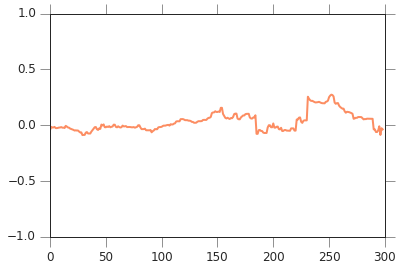

In [296]:
plt.plot(NDVI.mean(axis=1))
plt.xlim(0,300)
plt.ylim(-1,1)

In [309]:
NIR = predic[:,0,1,:].copy()
NIR[NIR>1]=np.nan

(0, 0.6)

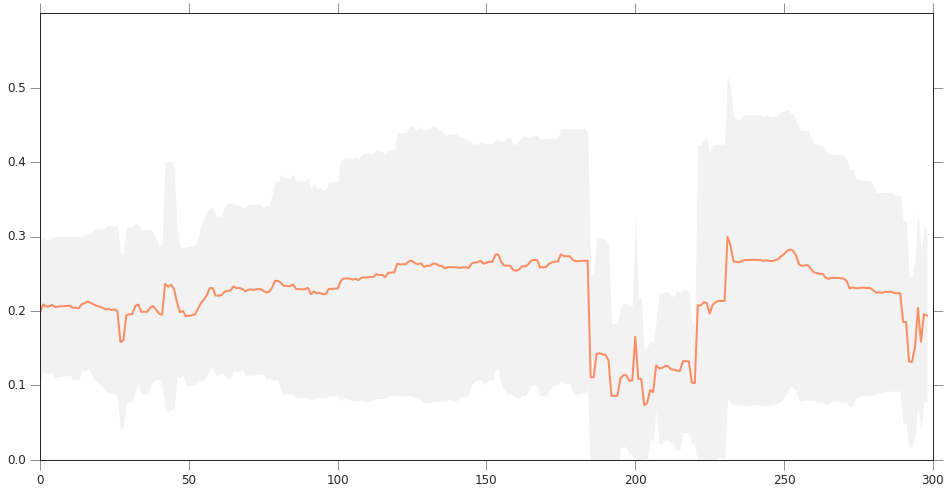

In [340]:
plt.figure(figsize=(16,8))
#plt.errorbar(range(0,299), np.nanmean(NIR, axis=1), yerr=np.nanstd(NIR, axis=1))
plt.plot(np.nanmean(NIR, axis=1))
plt.fill_between(range(0,299), np.nanmean(NIR, axis=1), np.nanmean(NIR, axis=1)+np.nanstd(NIR, axis=1), facecolor='grey', alpha=0.1)
plt.fill_between(range(0,299), np.nanmean(NIR, axis=1), np.nanmean(NIR, axis=1)-np.nanstd(NIR, axis=1), facecolor='grey', alpha=0.1)
plt.xlim(0,300)
plt.ylim(0,0.6)

(0, 0.5)

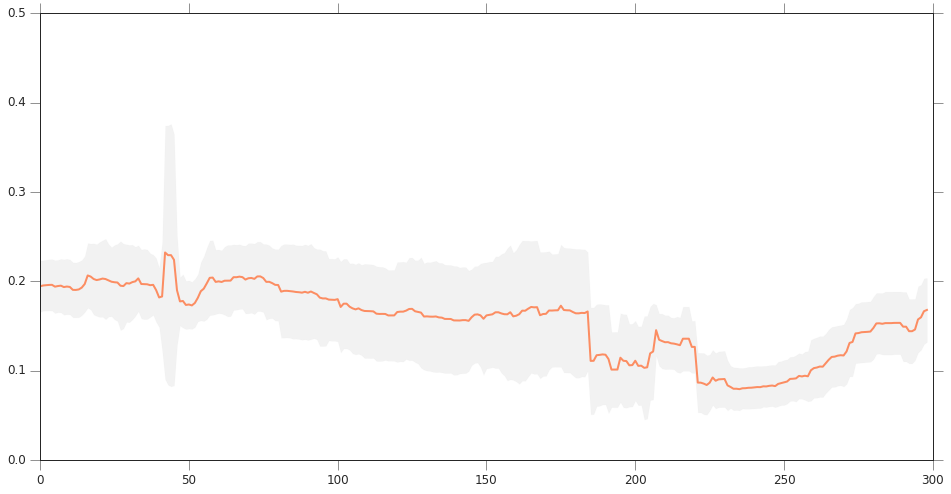

In [342]:
plt.figure(figsize=(16,8))
#plt.errorbar(range(0,299), np.nanmean(NIR, axis=1), yerr=np.nanstd(NIR, axis=1))
plt.plot(np.nanmean(red, axis=1))
plt.fill_between(range(0,299), np.nanmean(red, axis=1), np.nanmean(red, axis=1)+np.nanstd(red, axis=1), facecolor='grey', alpha=0.1)
plt.fill_between(range(0,299), np.nanmean(red, axis=1), np.nanmean(red, axis=1)-np.nanstd(red, axis=1), facecolor='grey', alpha=0.1)
plt.xlim(0,300)
plt.ylim(0,0.5)

In [414]:
S2_doy = [251,241,211,131,121,101,41]
land_doy = [38, 70,86, 134, 150]

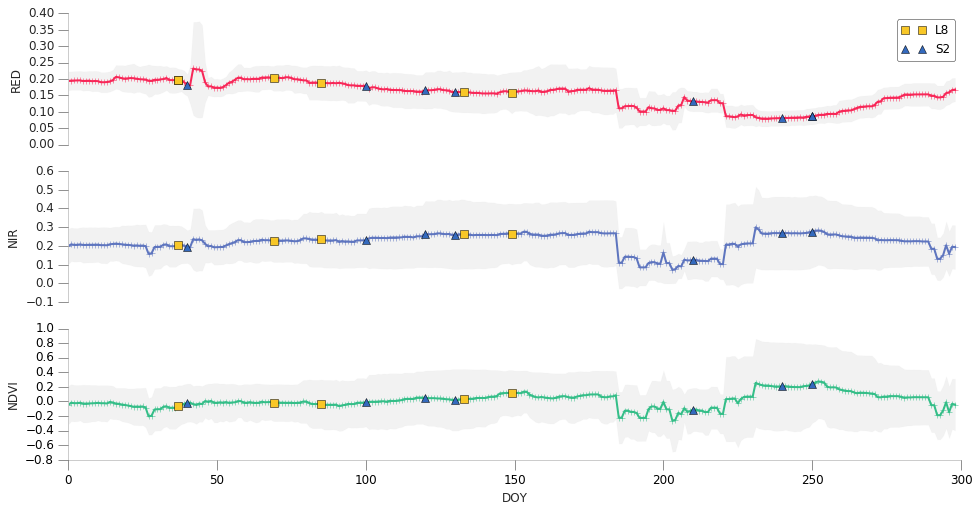

In [445]:
red = predic[:,0,0,:].copy()
red[red>1]=np.nan
NDVI = (NIR - red)/(NIR + red)
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(3,1,1)
ax1.plot(np.nanmean(red, axis=1), '-+', color='#f82758', rasterized=True)
ax1.fill_between(range(0,299), np.nanmean(red, axis=1), np.nanmean(red, axis=1)+np.nanstd(red, axis=1), facecolor='grey', alpha=0.1)
ax1.fill_between(range(0,299), np.nanmean(red, axis=1), np.nanmean(red, axis=1)-np.nanstd(red, axis=1), facecolor='grey', alpha=0.1)
plt.tick_params( axis='x', top='off', bottom='off', right='off',labelcolor='None')
plt.tick_params( axis='y', right='off')
ax1.spines['top'].set_color('none')
ax1.spines['bottom'].set_color('none')
ax1.spines['left'].set_color('0.8')
ax1.spines['right'].set_color('none')
ax1.set_ylabel('RED')
i=38;j=251
ax1.plot(i-1,np.nanmean(red, axis=1)[i-1], 's',color='#f8c727', markersize=8,label='L8')
ax1.plot(j-1,np.nanmean(red, axis=1)[j-1], '^',color='#346abe', markersize=8,label='S2')
plt.legend()

ax2 = fig.add_subplot(3,1,2)
ax2.plot(np.nanmean(NIR, axis=1), '-+', color='#5e75bf',rasterized=True)
ax2.fill_between(range(0,299), np.nanmean(NIR, axis=1), np.nanmean(NIR, axis=1)+np.nanstd(NIR, axis=1), facecolor='grey', alpha=0.1)
ax2.fill_between(range(0,299), np.nanmean(NIR, axis=1), np.nanmean(NIR, axis=1)-np.nanstd(NIR, axis=1), facecolor='grey', alpha=0.1)
plt.tick_params( axis='x', top='off', bottom='off', right='off',labelcolor='None')
plt.tick_params( axis='y', right='off')
ax2.spines['top'].set_color('none')
ax2.spines['bottom'].set_color('none')
ax2.spines['left'].set_color('0.8')
ax2.spines['right'].set_color('none')
ax2.set_ylabel('NIR')


ax3 = fig.add_subplot(3,1,3)
ax3.plot(np.nanmean(NDVI, axis=1), '-+', color='#34be88', rasterized=True)
ax3.fill_between(range(0,299), np.nanmean(NDVI, axis=1),np.nanmean(NDVI, axis=1)+np.nanstd(NDVI, axis=1),facecolor='grey', alpha=0.1 )
ax3.fill_between(range(0,299), np.nanmean(NDVI, axis=1),np.nanmean(NDVI, axis=1)-np.nanstd(NDVI, axis=1),facecolor='grey', alpha=0.1 )
plt.tick_params(labelcolor='k', top='off', right='off')
ax3.spines['top'].set_color('none')
ax3.spines['bottom'].set_color('0.8')
ax3.spines['left'].set_color('0.8')
ax3.spines['right'].set_color('none')
S2_doy = [251,241,211,131,121,101,41]
land_doy = [38, 70,86, 134, 150]


for i in land_doy:
    #ax1.plot(i-1,np.nanmean(red, axis=1)[i-1], 's',color='#f8c727', markersize=8)
    ax2.plot(i-1,np.nanmean(NIR, axis=1)[i-1], 's',color='#f8c727', markersize=8)
    ax3.plot(i-1,np.nanmean(NDVI, axis=1)[i-1], 's',color='#f8c727', markersize=8)

    ax1.plot(i-1,np.nanmean(red, axis=1)[i-1], 's',color='#f8c727', markersize=8)
for j in S2_doy:
    #ax1.plot(j-1,np.nanmean(red, axis=1)[j-1], '^',color='#346abe',markersize=8,label='S2')
    ax2.plot(j-1,np.nanmean(NIR, axis=1)[j-1], '^',color='#346abe', markersize=8)
    ax3.plot(j-1,np.nanmean(NDVI, axis=1)[j-1], '^',color='#346abe', markersize=8)        
    ax1.plot(j-1,np.nanmean(red, axis=1)[j-1], '^',color='#346abe', markersize=8) 



#plt.ylim(-1,1)
#plt.yticks([0,0.5,1,1.5,2,2.5,3 ],['0','0.5', '0','0.5', '0','0.5','1'])
plt.legend(loc=1)
ax3.set_ylabel('NDVI')
ax3.set_xlabel('DOY')
plt.savefig('image/Temporal_changes.pdf', dpi=400)